# Inicializacion

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from fun_gilles import *
import cmcrameri.cm as cmc
import pandas as pd

In [3]:
def plot(abundances, times, V):
    colors = cmc.berlin(np.linspace(0, 1, len(SPECIES)))

    # --- Create the figure and a 1-row, 3-column subplot grid ---
    # Using a wide figsize for a horizontal layout.
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True) 
    # Note: sharex=True is removed because we need the x-axis ticK_CONSTANTSs on all three plots, 
    # although they are the same (time).

    # --- Subplot 1 (Left): Concentration ---
    ax1 = axes[0]
    for i in range(len(SPECIES)):
        # Calculate Concentration = Abundance / Volume
        ax1.plot(times, abundances[:, i] / V, label=SPECIES[i], color=colors[i], alpha=0.9)
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Concentration")
    ax1.set_title("Concentration Evolution")
    ax1.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title="SPECIES")


    # --- Subplot 2 (Middle): Volume ---
    ax2 = axes[1]
    ax2.plot(times, V, color='gray')
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Volume")
    ax2.set_title("Volume Evolution")


    # --- Final Touches ---
    # Add a figure-wide title
    fig.suptitle(fr"Simulation Results ($K_1$ = {K_CONSTANTS[1]/K_CONSTANTS[0]}, $K_2$ = {K_CONSTANTS[3]/K_CONSTANTS[2]}, $K_3$ = {K_CONSTANTS[5]/K_CONSTANTS[4]}, $K_4$ = {K_CONSTANTS[7]/K_CONSTANTS[6]})",
                 fontsize=16)

    # Adjust layout to prevent labels/titles from overlapping
    plt.tight_layout(rect=[0, 0, 1, 1]) # Adjust tight_layout for a single row

    plt.show()

# Simulación

In [12]:
# --- 1. PARAMETER DEFINITION ---
# Volume range: 1e2 to 1e6 (using logarithmic steps)
VOLUME_EXPONENTS = np.arange(2, 5.5, 0.5) # [2.0, 2.5, 3.0, ..., 6.0]
VOLUMES = 10**VOLUME_EXPONENTS

# Fixed initial concentrations (mol/L)
INITIAL_CONCENTRATIONS = {
    'a': 1.0,
    'b': 1.0,
    'c': 1.0,
    'd': 1.0,
    'ab': 0.5,
    'cd': 0.5,
    'cab': 0.0,
    'acd': 0.0
}

# Fixed parameters for the simulation
# Adjust these based on your specific reactions file
REACTIONS_FILE = "../examples/reactions_autocat.txt" 
K_CONSTANTS = [1.0] * 8  # Example: ensure length matches number of reactions
SD_THRESHOLD = 0     # Convergence threshold
MAX_ITERATIONS = VOLUMES * 2  # Safety limit for gillespieProtocell

# Load species list from your file to ensure correct ordering
reactions = read_file(REACTIONS_FILE)
SPECIES = obtain_species(reactions) 

Starting 7 simulations...

Running simulation for Volume V = 100


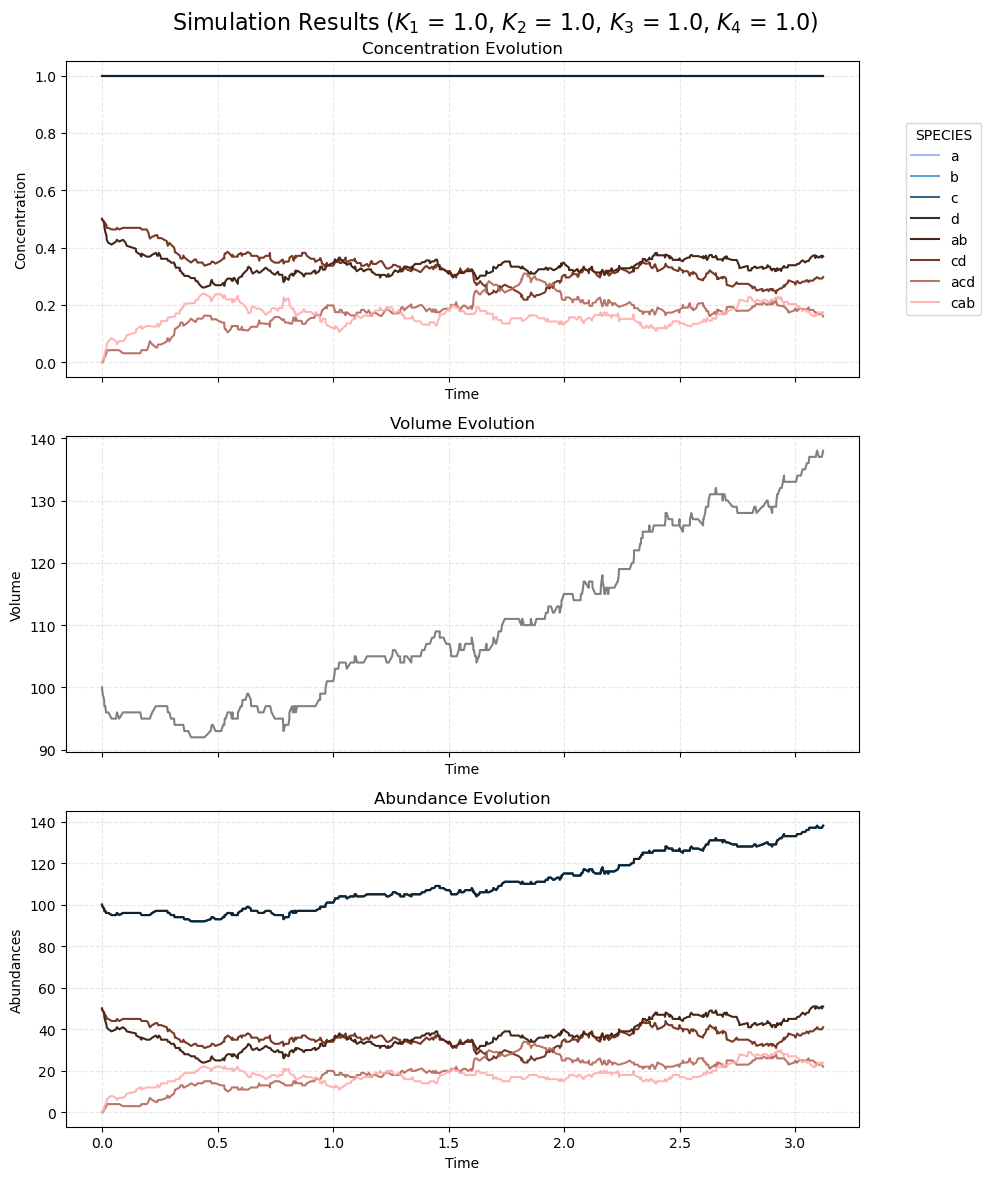

Finished V=100. Max SD in block: 5.4378e-02

Running simulation for Volume V = 316


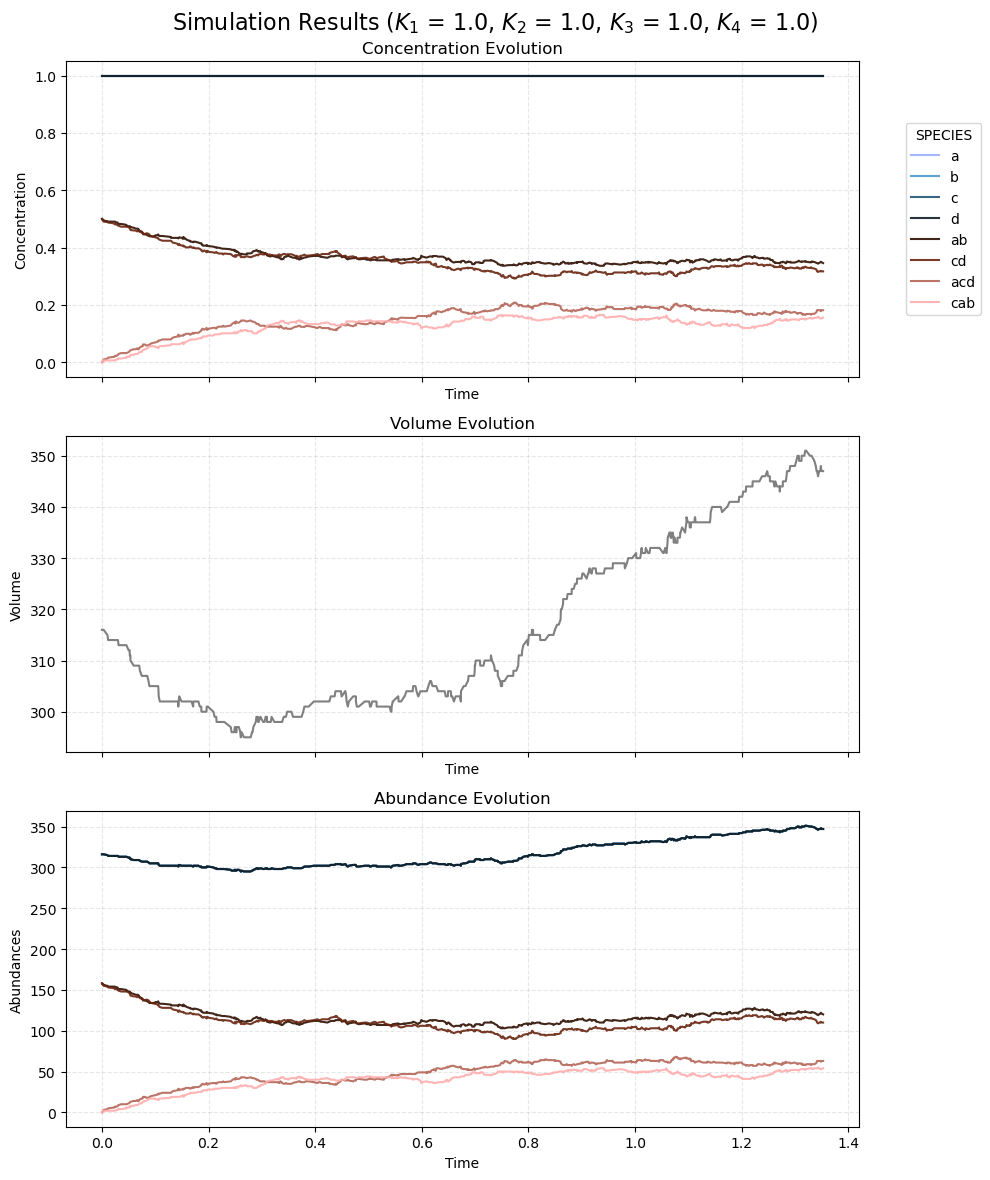

Finished V=316. Max SD in block: 2.4106e-02

Running simulation for Volume V = 1,000


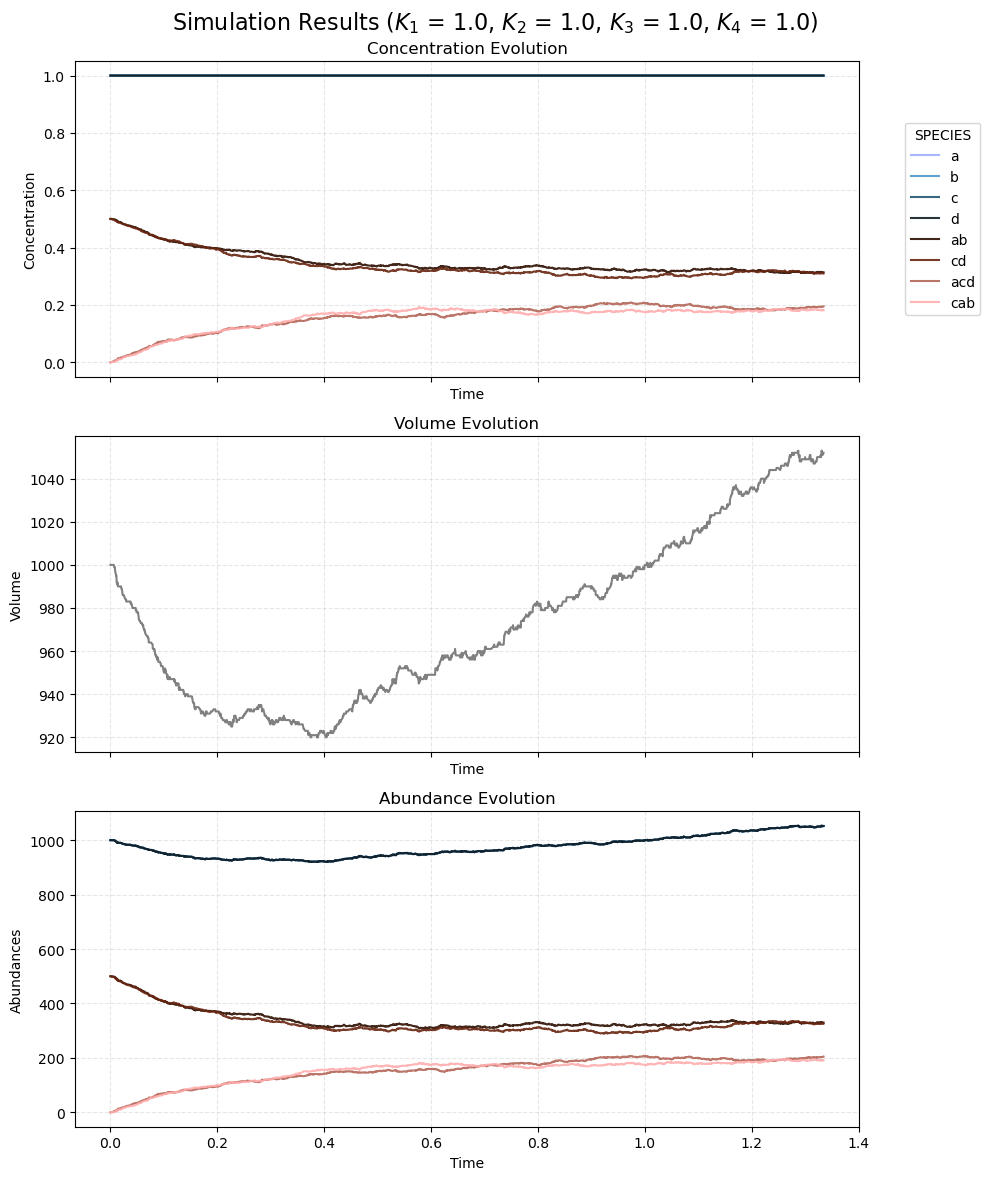

Finished V=1000. Max SD in block: 6.1394e-03

Running simulation for Volume V = 3,162


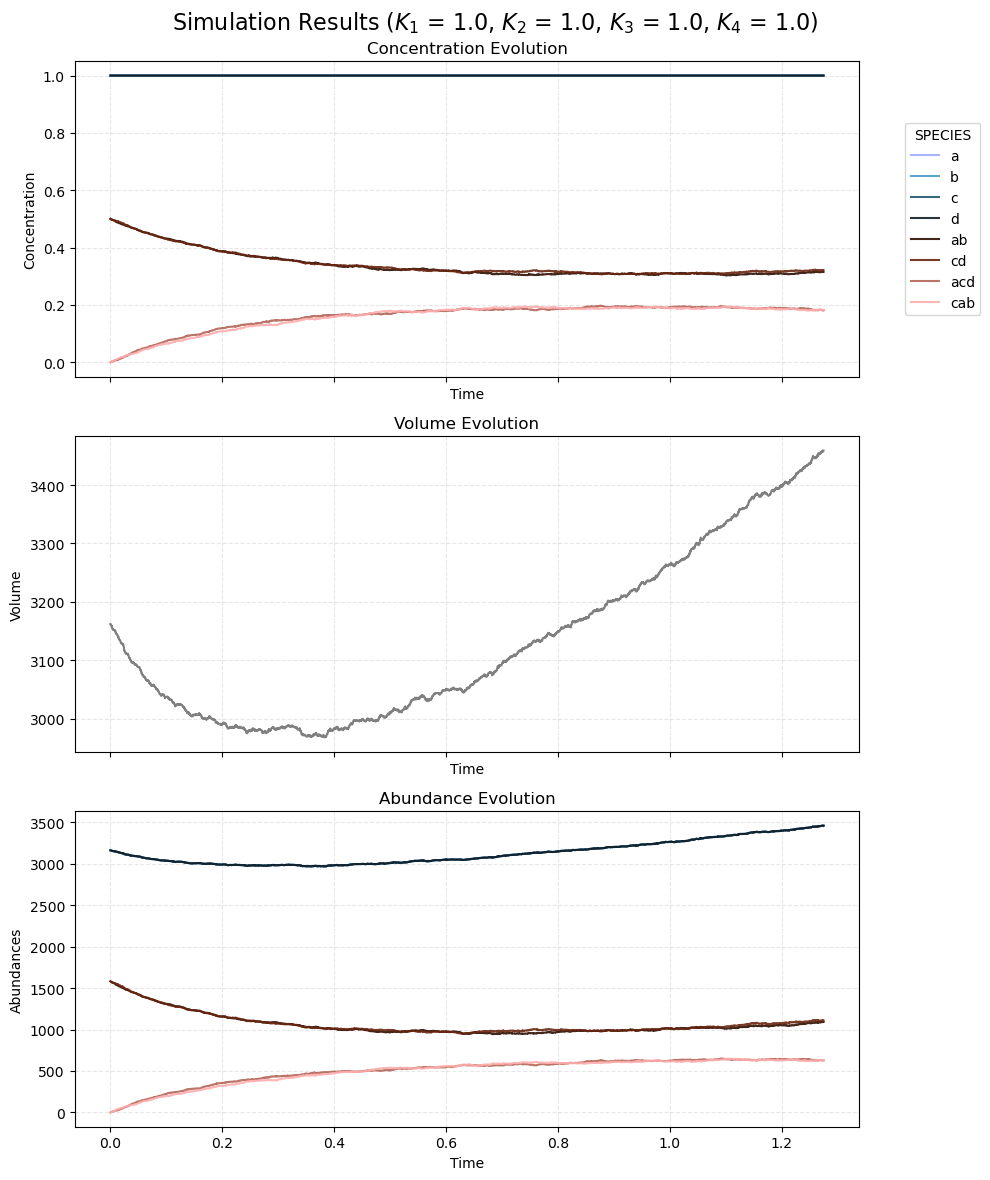

Finished V=3162. Max SD in block: 2.6458e-03

Running simulation for Volume V = 10,000


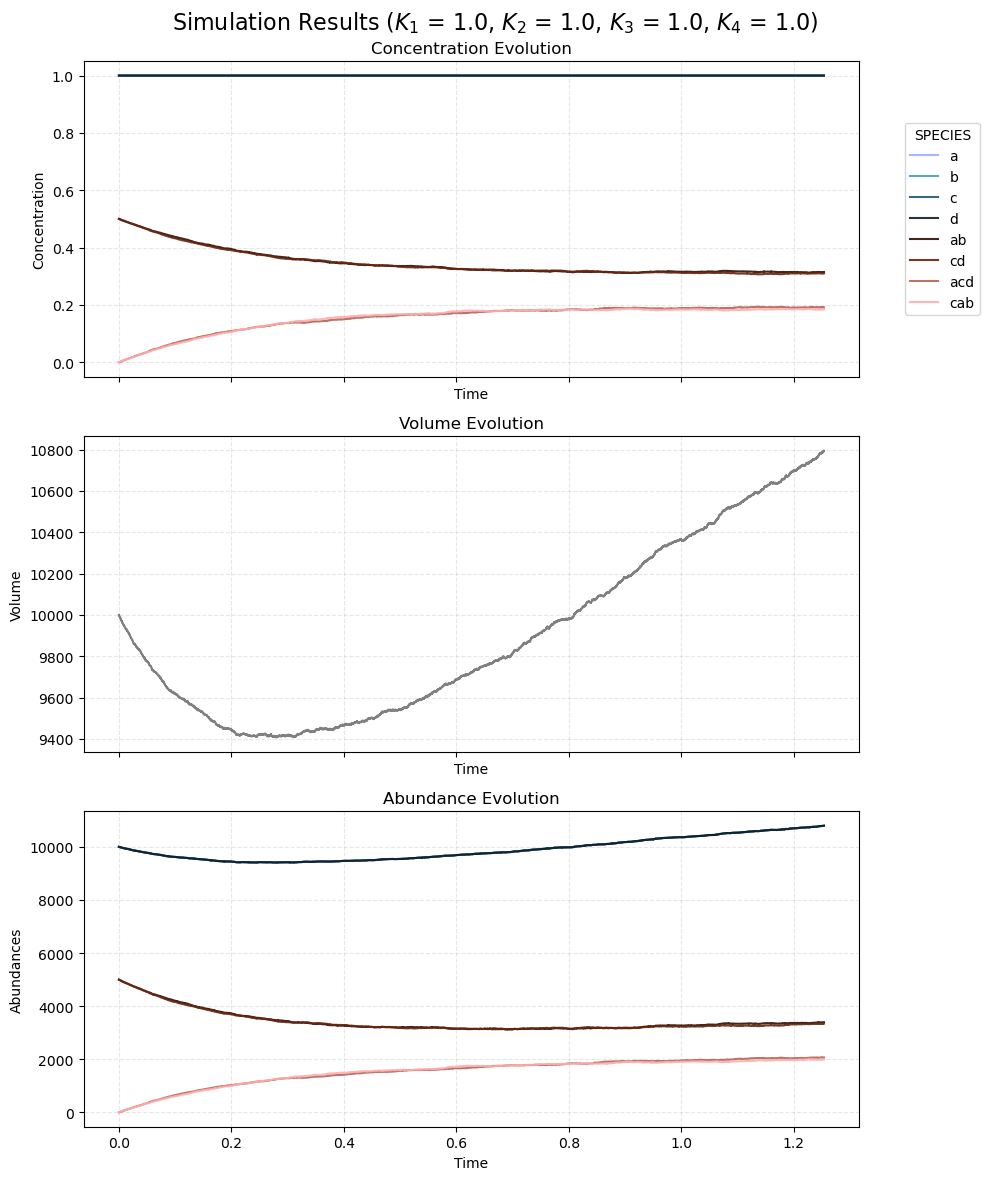

Finished V=10000. Max SD in block: 9.0932e-04

Running simulation for Volume V = 31,623


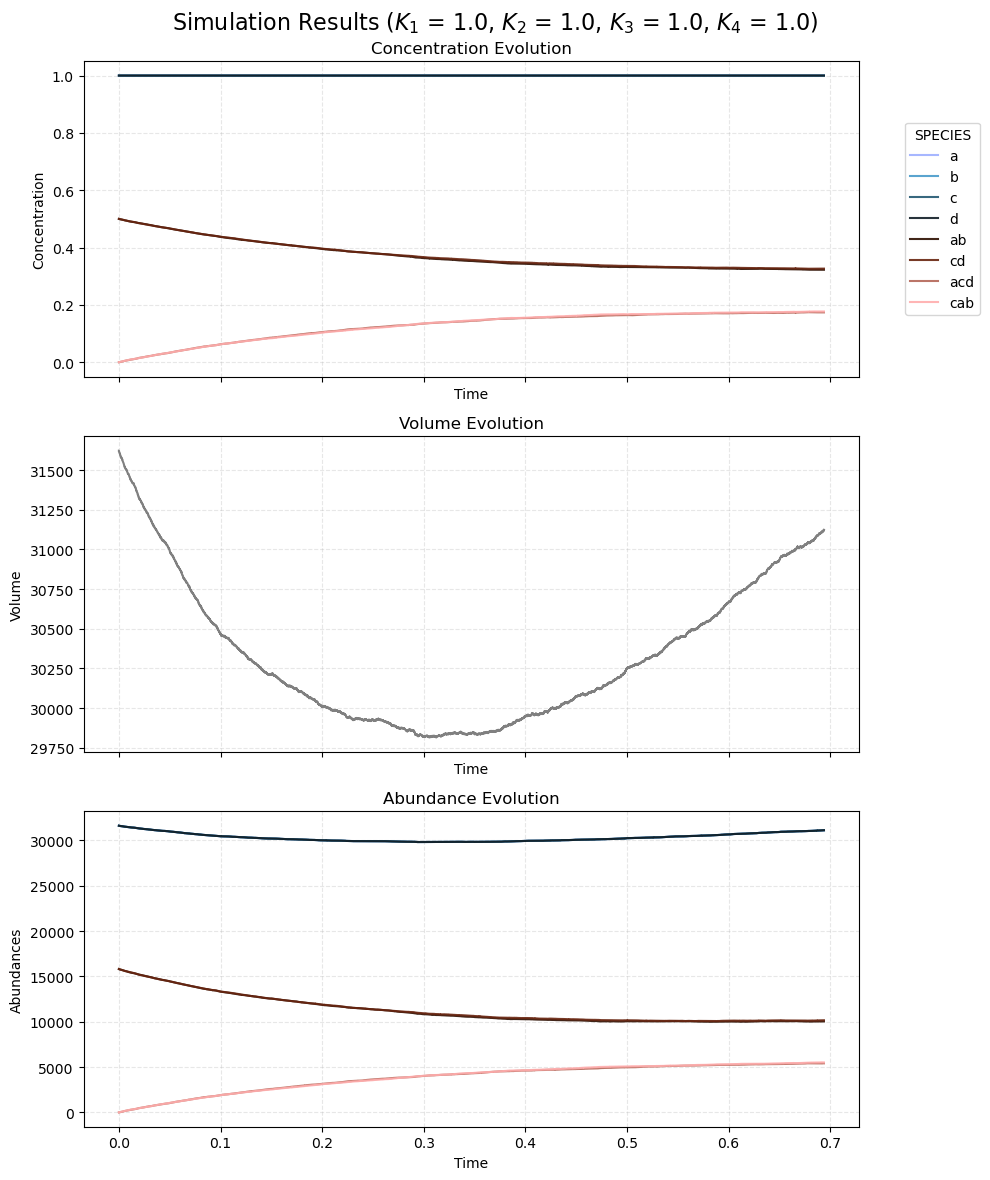

Finished V=31623. Max SD in block: 2.1008e-04

Running simulation for Volume V = 100,000


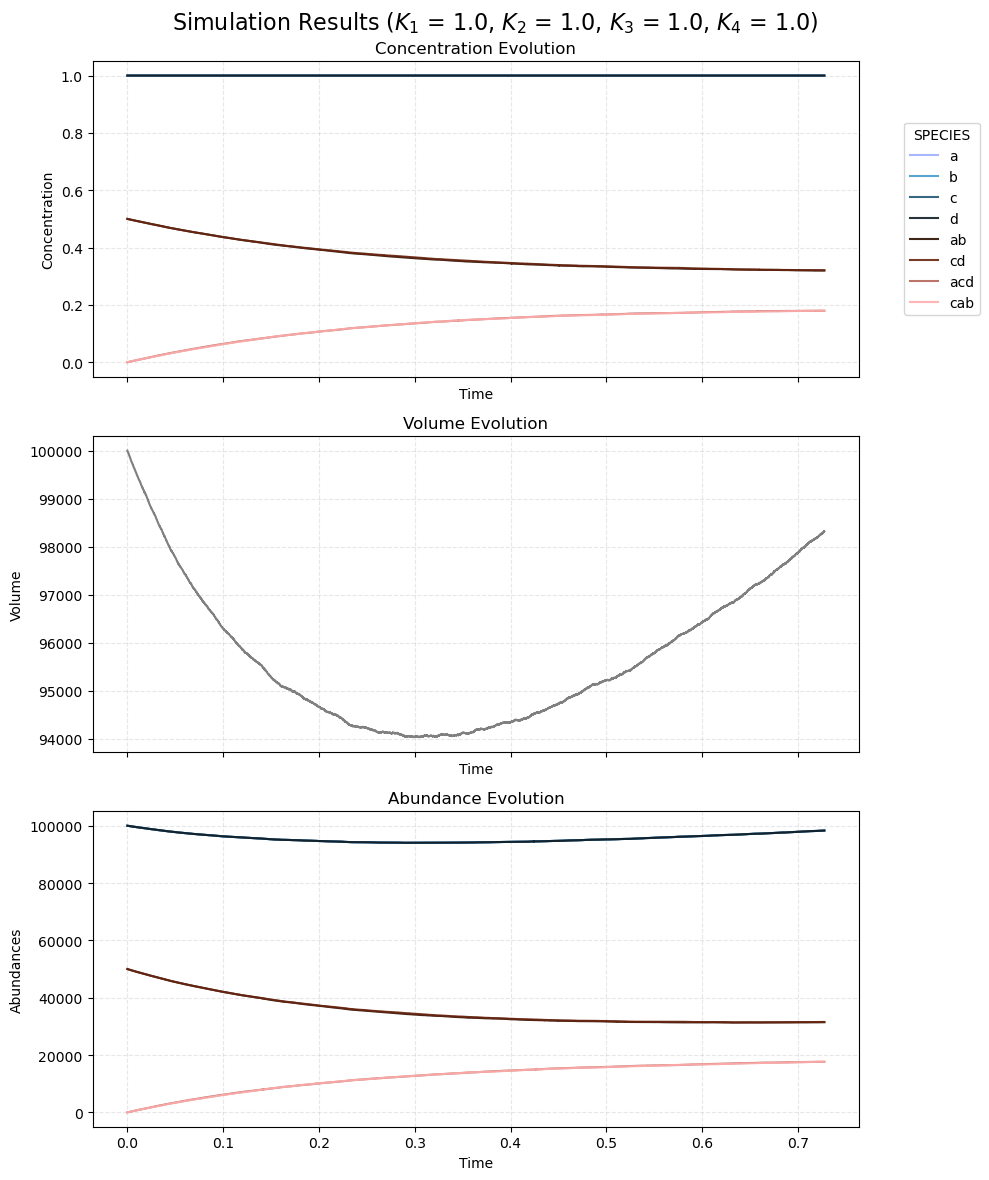

Finished V=100000. Max SD in block: 8.3820e-05


In [ ]:
# Storage for results: [Volume, SD_species_A, SD_species_B, ...]
results_list = []

# --- 2. SIMULATION LOOP ---
print(f"Starting {len(VOLUMES)} simulations...")
i=0
for V in VOLUMES:
    V = round(V) # Ensure Volume is a clean integer
    print(f"\nRunning simulation for Volume V = {V:,.0f}")
    
    # Calculate Initial Molecule Counts (N = C * V)
    initial_abundances = np.array([
        round(INITIAL_CONCENTRATIONS.get(s, 0.0) * V) for s in SPECIES
    ])
    
    # Run the simulation using the Protocell method and convergence threshold
    try:
        # chemistry calls gillespieProtocell(..., threshold)
        abundances, times, final_V = chemistry(
            method='Protocell', 
            iterations=max(MAX_ITERATIONS[i], 1e4), # Pass max_iterations as the safety limit
            reactions=reactions, 
            initial_food=initial_abundances, 
            k=K_CONSTANTS, 
            V=V, 
            threshold=SD_THRESHOLD # Passed via **kwargs logic
        )
        i += 1
        plot(abundances, times, final_V)
    except Exception as e:
        print(f"Simulation failed for V={V}: {e}")
        continue # Skip to the next volume

    # --- 3. ANALYSIS (Final Block SD) ---
    # The last 500 iterations are assumed to be the stationary block
    BLOCK_SIZE = 500
    
    if len(abundances) < BLOCK_SIZE:
        print(f"Skipping analysis: Simulation ended too soon (N={len(abundances)})")
        continue

    # 1. Slice the last block of data (Abundance)
    abundances_slice = abundances[-BLOCK_SIZE:, :]
    # 2. Slice the corresponding volumes
    V_slice = final_V[-BLOCK_SIZE:]
    
    # 3. Calculate Concentration: (Abundance / Volume) for the last block
    # Note the use of np.newaxis for correct broadcasting (from previous discussion)
    last_block_concentrations = abundances_slice / V_slice[:, np.newaxis]

    # 4. Calculate Block Statistics (only the SD is needed)
    # The block_statistics function returns (block_mean, block_std)
    _, block_std = block_statistics(last_block_concentrations)
    
    # 5. Store the results: [Volume, SD for species 0, SD for species 1, ...]
    results_row = [V] + block_std.tolist()
    results_list.append(results_row)
    
    print(f"Finished V={V}. Max SD in block: {np.max(block_std):.4e}")

# Convert results to a NumPy array for easier plotting
results_array = np.array(results_list)

In [3]:
results_array = np.array([[1.00000000e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.88996995e-02, 3.59308789e-02, 2.50635298e-02,
        2.53478989e-02],
       [3.16000000e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.89455422e-02, 1.57907967e-02, 2.04607160e-02,
        9.13930832e-03],
       [1.00000000e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.24304142e-03, 3.09924428e-03, 6.05651897e-03,
        4.17679065e-03],
       [3.16200000e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.95284473e-03, 1.29535945e-03, 1.47250388e-03,
        1.56358677e-03],
       [1.00000000e+04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.66069256e-04, 7.52847056e-04, 2.62733181e-04,
        5.92840131e-04],
       [3.16230000e+04, 3.61487084e-08, 3.61487084e-08, 3.61487084e-08,
        3.61487084e-08, 9.62452596e-05, 2.30632929e-04, 1.10047076e-04,
        2.16299286e-04],
       [1.00000000e+05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.65421552e-05, 3.99190138e-05, 1.59654313e-05,
        6.12949608e-05]])

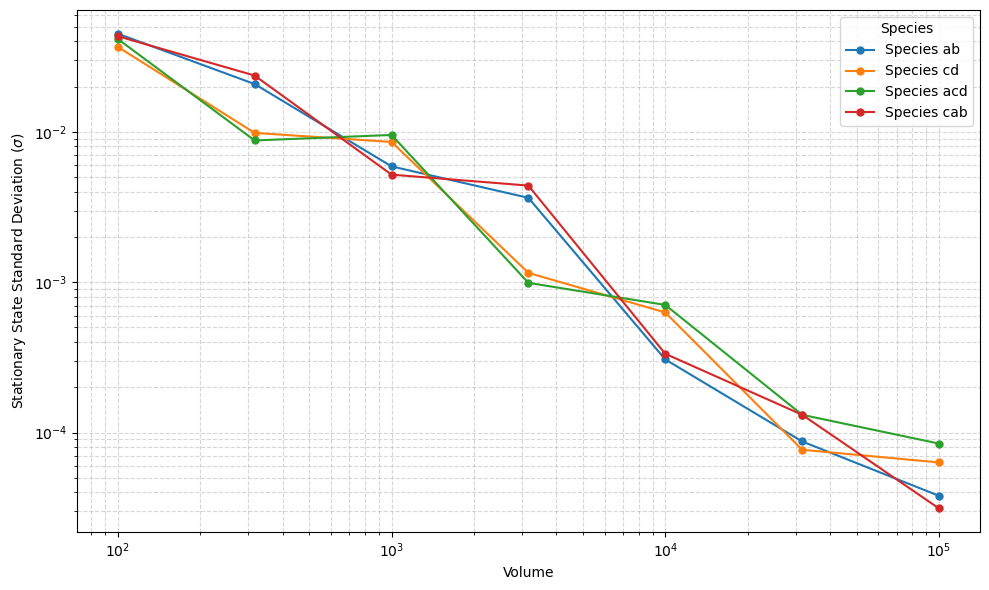

Plot generated successfully.


In [6]:
if results_array.size == 0:
    print("No successful simulation data to plot.")
else:
    volumes_plotted = results_array[:, 0]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot SD vs Volume for each species (skipping the first column, which is V)
    for i, species_name in enumerate(SPECIES):
        if species_name != 'a' and species_name != 'b' and species_name != 'c' and species_name != 'd':
            std_devs = results_array[:, i + 1] # SD starts at column 1
            
            # We expect a relationship close to Noise ~ 1/sqrt(V)
            # Plotting on log-log axes is standard for noise analysis.
            ax.loglog(volumes_plotted, std_devs, 
                    marker='o', linestyle='-', markersize=5, 
                    label=fr'Species {species_name}'
            )

    ax.set_xlabel('Volume')
    ax.set_ylabel(r'Stationary State Standard Deviation ($\sigma$)')
    ax.grid(True, which="both", ls="--", alpha=0.5)
    ax.legend(title='Species')
    
    plt.tight_layout()
    plt.show()
    print("Plot generated successfully.")

In [7]:
import numpy as np
import pandas as pd

# Data estimated from your plot (reusing the assumed data from the previous step)
VOLUMES = results_array[:,0]

# Example: Using the measured SD for Species ab (as one representative example)
# In practice, you'd calculate A for the species that drives the convergence.
SD_ab = results_array[:,5]

# For a single general threshold, we'll use the maximum SD across all species at each volume.
# Let's define the 'driving' SD (the largest noise source)
SD_cd = results_array[:,6]
SD_acd = results_array[:,7]
SD_cab = results_array[:,8]

# Find the maximum SD among the species for each volume (this determines when max(std) stops decreasing)
all_sds = np.vstack([SD_ab, SD_cd, SD_acd, SD_cab])
driving_SD = np.max(all_sds, axis=0)

In [7]:
from numpy.polynomial.polynomial import polyfit

def get_scaling_threshold(volumes: np.ndarray, driving_sds: np.ndarray, margin: float = 0.05):
    """
    Fits the stationary state standard deviation (sigma) to the scaling law 
    sigma = A / sqrt(V) and returns a function to predict the threshold for any volume.

    Args:
        volumes (np.ndarray): Array of measured volumes (V).
        driving_sds (np.ndarray): Array of the maximum measured stationary SD 
                                  across all species for each volume.
        margin (float): Relative safety margin (e.g., 0.05 for 5%) to add to 
                        the predicted SD.

    Returns:
        function: A function that takes a new volume (V_new) and returns the 
                  recommended SD threshold.
    """
    
    # 1. Linearize the axes: log(sigma) vs. log(V)
    log_V = np.log(volumes)
    log_sigma = np.log(driving_sds)
    
    # 2. Perform Linear Regression: log(sigma) = m * log(V) + log(A)
    # The expected slope 'm' is -0.5. polyfit forces a fit to a straight line.
    # Returns [log(A), slope]
    coefficients = polyfit(log_V, log_sigma, 1)
    
    # Extract the intercept (log(A)) and slope (m)
    log_A_fit = coefficients[0]
    m_fit = coefficients[1] 
    # 3. Calculate the scaling constant A
    A_fit = np.exp(log_A_fit)
    
    print(f"Regression completed. Fitted Scaling Constant A: {A_fit:.3f}\
        \nFitted slope m: {m_fit:.3f}")
    
    # 4. Return the predictive function
    def threshold_function(V_new: float) -> float:
        """
        Predicts the required SD threshold for a new volume V_new.
        Threshold = (A / V_new^m) * (1 + margin)
        """
        if V_new <= 0:
            raise ValueError("Volume must be positive.")
            
        predicted_sigma = A_fit * (V_new) ** m_fit
        threshold = predicted_sigma * (1 + margin)
        return threshold

    return threshold_function

In [9]:
# --- Final Execution ---

# 1. Fit the scaling law to your data
threshold_predictor = get_scaling_threshold(VOLUMES, driving_SD, margin=0.)

# 2. Use the returned function to predict thresholds for new, unseen volumes
V_new_example_1 = 5000 
V_new_example_2 = 800000

sd_threshold_1 = threshold_predictor(V_new_example_1)
sd_threshold_2 = threshold_predictor(V_new_example_2)

print("\n--- Example Predictions ---")
print(f"Predicted SD Threshold for V={V_new_example_1}: {sd_threshold_1:.4e}")
print(f"Predicted SD Threshold for V={V_new_example_2}: {sd_threshold_2:.4e}")

Regression completed. Fitted Scaling Constant A: 6.595        
Fitted slope m: -0.987

--- Example Predictions ---
Predicted SD Threshold for V=5000: 1.4692e-03
Predicted SD Threshold for V=800000: 9.7924e-06


Regression completed. Fitted Scaling Constant A: 6.595        
Fitted slope m: -0.987


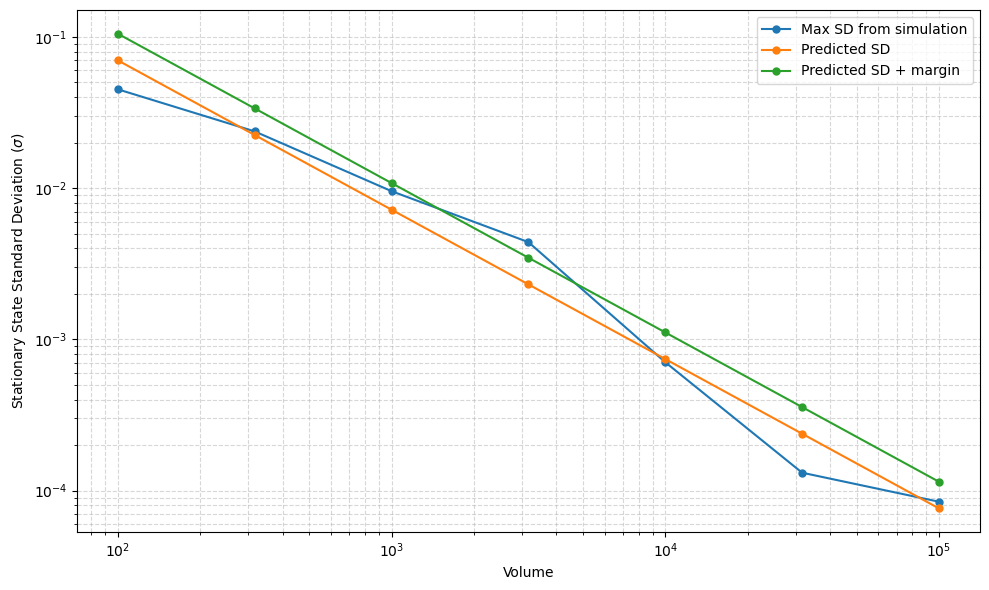

Plot generated successfully.


In [14]:
# --- PLOTTING THE FITTED VALUES FOR THRESHOLD ---
volumes_plotted = results_array[:, 0]

fig, ax = plt.subplots(figsize=(10, 6))


# We expect a relationship close to Noise ~ 1/sqrt(V)
# Plotting on log-log axes is standard for noise analysis.
ax.loglog(volumes_plotted, driving_SD, 
        marker='o', linestyle='-', markersize=5, 
        label=fr'Max SD from simulation'
)

threshold_predicted = []
for v in volumes_plotted:
        threshold_predicted.append(threshold_predictor(v))

threshold_predicted = np.array(threshold_predicted)

ax.loglog(volumes_plotted, threshold_predicted, 
        marker='o', linestyle='-', markersize=5, 
        label=fr'Predicted SD'
)

# Now with margin
threshold_predictor_w_margin = get_scaling_threshold(VOLUMES, driving_SD, margin=0.5)
threshold_predicted_w_margin = []
for v in volumes_plotted:
        threshold_predicted_w_margin.append(threshold_predictor_w_margin(v))

threshold_predicted_w_margin = np.array(threshold_predicted_w_margin)

ax.loglog(volumes_plotted, threshold_predicted_w_margin, 
        marker='o', linestyle='-', markersize=5, 
        label=fr'Predicted SD + margin'
)

ax.set_xlabel('Volume')
ax.set_ylabel(r'Stationary State Standard Deviation ($\sigma$)')
ax.grid(True, which="both", ls="--", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()
print("Plot generated successfully.")

# concentración

In [14]:
import numpy as np
from numpy.polynomial.polynomial import polyfit
from typing import Callable

def get_universal_threshold_predictor(
    stationary_concentrations: np.ndarray, 
    fitted_A_values: np.ndarray, 
    margin: float = 0.05
) -> Callable[[float, float], float]:
    """
    Fits the relationship A = B * C_key^beta to generalize the SD threshold 
    for any volume (V) and any stationary concentration (C_key).

    The final predictive model is: Threshold = (B * C_key^beta) / sqrt(V) * (1 + margin)

    Args:
        stationary_concentrations (np.ndarray): Array of the stationary 
                                                concentrations (C_key) observed
                                                across different initial setups.
        fitted_A_values (np.ndarray): Array of the fitted noise magnitude 
                                      constants (A) corresponding to each C_key.
        margin (float): Relative safety margin (e.g., 0.05 for 5%) to add to 
                        the predicted SD.

    Returns:
        Callable[[float, float], float]: A function that takes (V_new, C_key_run) 
                                         and returns the recommended SD threshold.
    """
    
    # --- Step 1: Linearize the Axes ---
    # We fit the equation: log(A) = beta * log(C_key) + log(B)
    log_C_key = np.log(stationary_concentrations)
    log_A = np.log(fitted_A_values)
    
    # --- Step 2: Perform Linear Regression (Second Fit) ---
    # Returns [log(B), beta]
    # Note: We are fitting a polynomial of degree 1 (a straight line)
    coefficients = polyfit(log_C_key, log_A, 1)
    
    # Extract the intercept (log(B)) and slope (beta)
    log_B_fit = coefficients[0]
    beta_fit = coefficients[1]

    # --- Step 3: Calculate the universal scaling constant B ---
    B_fit = np.exp(log_B_fit)
    
    print(f"Universal Constant B fitted: {B_fit:.3e}")
    print(f"Concentration Exponent beta fitted: {beta_fit:.3f}")
    
    # --- Step 4: Return the predictive function ---
    def universal_threshold_function(V_new: float, C_key_run: float) -> float:
        """
        Predicts the required SD threshold for a new simulation setup.
        """
        if V_new <= 0 or C_key_run <= 0:
            return np.inf # Return infinity if inputs are invalid

        # 1. Predict the noise constant A for the current concentration (A = B * C_key^beta)
        predicted_A = B_fit * (C_key_run ** beta_fit)
        
        # 2. Predict the stationary sigma for the current volume (sigma = A / sqrt(V))
        predicted_sigma = predicted_A / np.sqrt(V_new)
        
        # 3. Apply the safety margin
        threshold = predicted_sigma * (1 + margin)
        return threshold

    return universal_threshold_function

# End of function definition

In [15]:
# --- SIMULATED DATA (Based on observation that A changes with C_key) ---
# Assume three simulation setups were run, each with different C_initials.
# We monitored a KEY species, X_key, and determined its stationary C and fitted A.

# DATA LAYER 2: A vs. C_key
# The stationary concentration (C_key) of the monitored species
C_key_stationary = np.array([0.5, 1.0, 2.0]) 

# The fitted noise constant (A) derived from the sigma vs. V plot for each C_key
# Note: A should increase as C_key increases in many bimolecular systems (A ~ C_key^1/2)
A_fitted_values = np.array([0.02, 0.03, 0.045]) 
# ------------------------------------------------------------------------

# 1. Generate the Universal Predictor
universal_predictor = get_universal_threshold_predictor(
    stationary_concentrations=C_key_stationary,
    fitted_A_values=A_fitted_values,
    margin=0.05  # 5% safety margin
)

# 2. Example of use inside the gillespieProtocell loop:
#    Suppose you are at iteration n=5000, and you check convergence.

V_current = 5000.0 # The current volume of the protocell
# Calculate the stationary concentration of the key species from the last block
C_key_run_time = 1.25 # Stationary concentration of X_key averaged over the last 500 iterations

# Calculate the required threshold
required_threshold = universal_predictor(V_current, C_key_run_time)

print("\n--- Usage Example ---")
print(f"Current Volume (V): {V_current:.0f}")
print(f"Current C_key (C_run): {C_key_run_time:.2f}")
print(f"Required SD Threshold: {required_threshold:.4e}")

Universal Constant B fitted: 3.000e-02
Concentration Exponent beta fitted: 0.585

--- Usage Example ---
Current Volume (V): 5000
Current C_key (C_run): 1.25
Required SD Threshold: 5.0759e-04


# barrido concentraciones:

Starting simulations for catalyst concentration = 0.1
Starting 7 simulations...

Running simulation for Volume V = 100
Criterion for stop was # of iterations


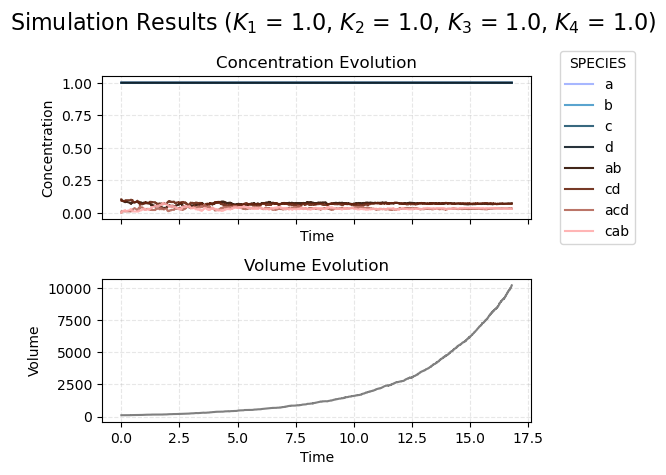

Finished V=100. Max SD in block: 5.1615e-04

Running simulation for Volume V = 316
Criterion for stop was # of iterations


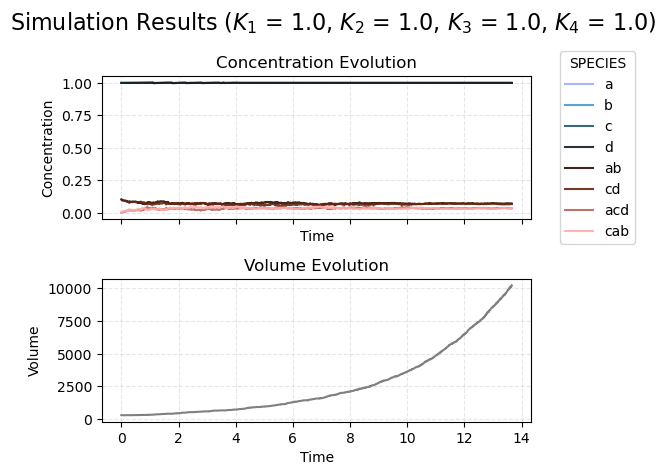

Finished V=316. Max SD in block: 7.7503e-04

Running simulation for Volume V = 1,000
Criterion for stop was # of iterations


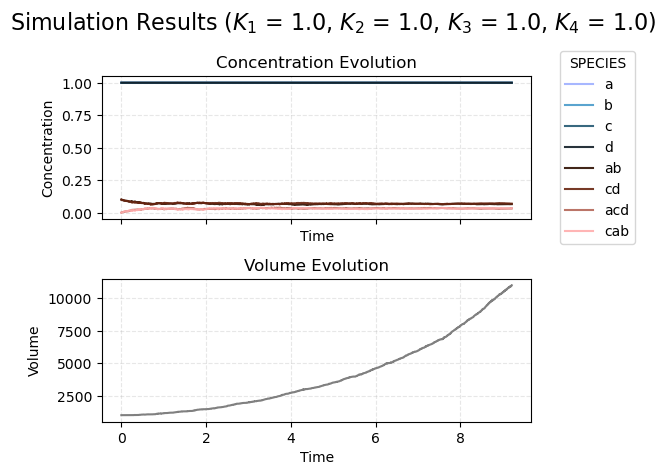

Finished V=1000. Max SD in block: 8.8729e-04

Running simulation for Volume V = 3,162
Criterion for stop was # of iterations


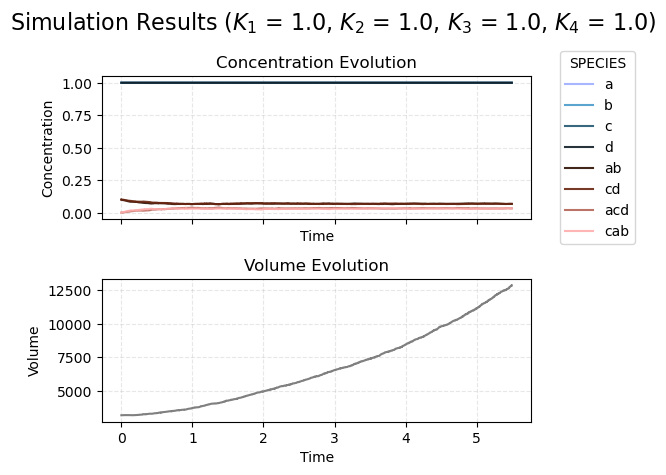

Finished V=3162. Max SD in block: 7.7086e-04

Running simulation for Volume V = 10,000
Criterion for stop was # of iterations


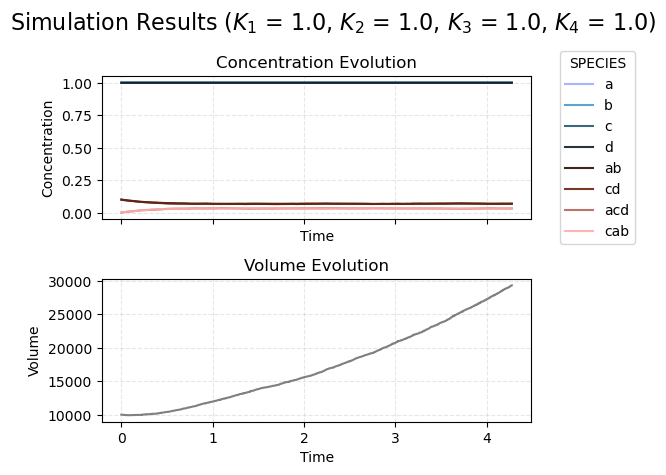

Finished V=10000. Max SD in block: 2.8405e-04

Running simulation for Volume V = 31,623
Criterion for stop was # of iterations


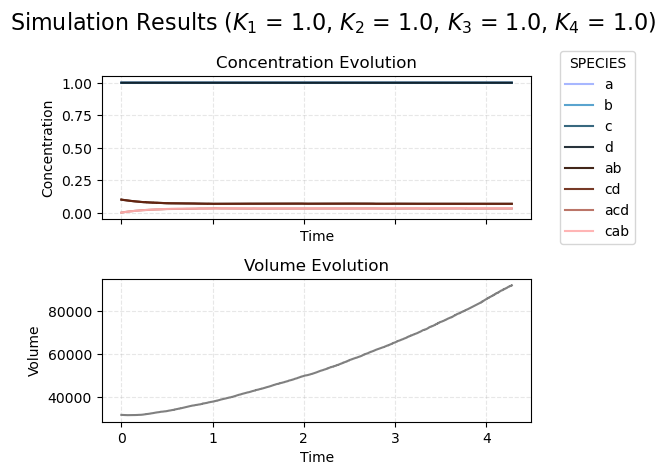

Finished V=31623. Max SD in block: 1.1160e-04

Running simulation for Volume V = 100,000
Criterion for stop was # of iterations


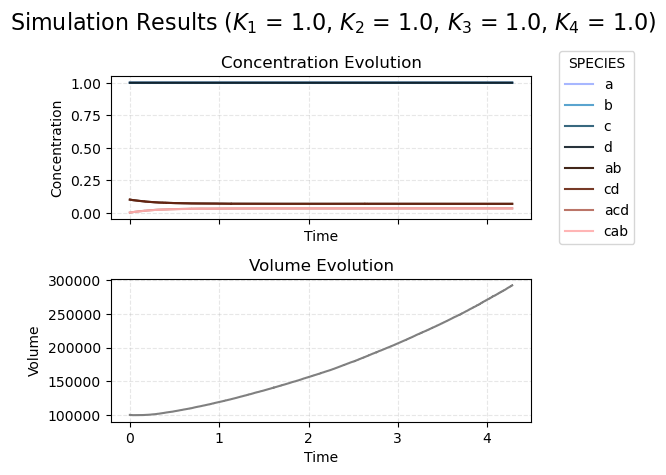

Finished V=100000. Max SD in block: 3.2479e-05


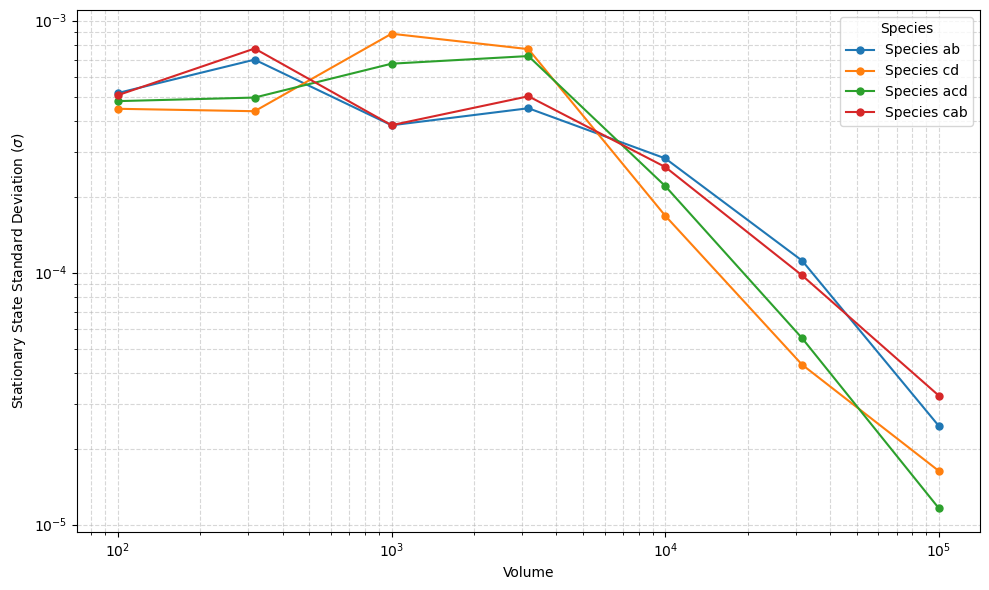

Plot generated successfully.
Regression completed. Fitted Scaling Constant A: 0.009        
Fitted slope m: -0.413

--- Example Predictions ---
Predicted SD Threshold for V=5000: 2.5742e-04
Predicted SD Threshold for V=800000: 3.1656e-05
Regression completed. Fitted Scaling Constant A: 0.009        
Fitted slope m: -0.413


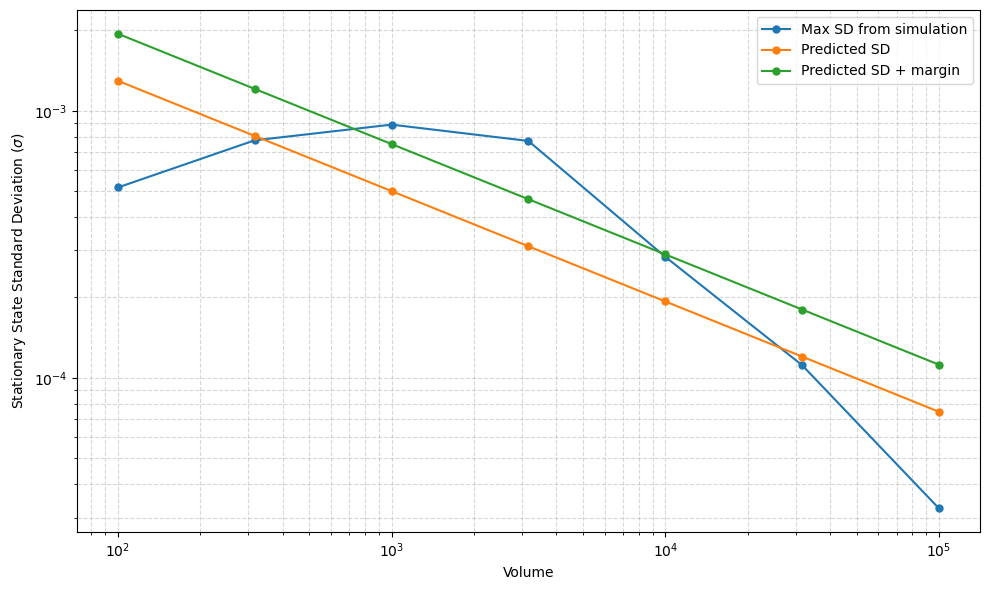

Plot generated successfully.
Starting simulations for catalyst concentration = 0.2
Starting 7 simulations...

Running simulation for Volume V = 100
Criterion for stop was # of iterations


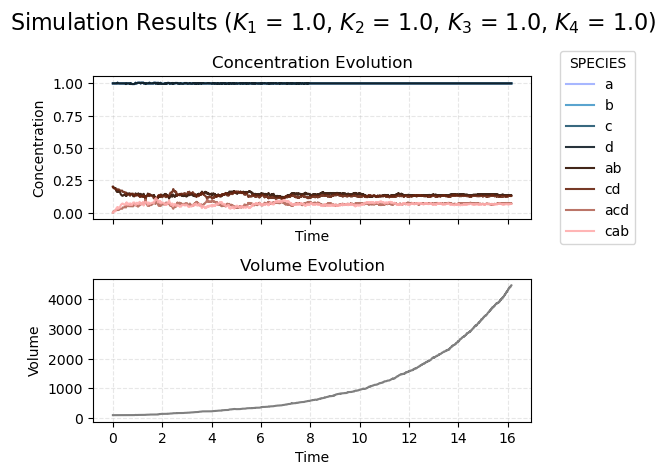

Finished V=100. Max SD in block: 1.3727e-03

Running simulation for Volume V = 316
Criterion for stop was # of iterations


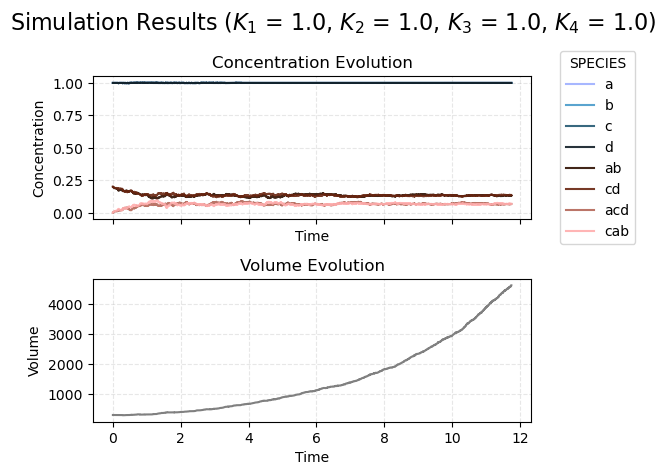

Finished V=316. Max SD in block: 1.0332e-03

Running simulation for Volume V = 1,000
Criterion for stop was # of iterations


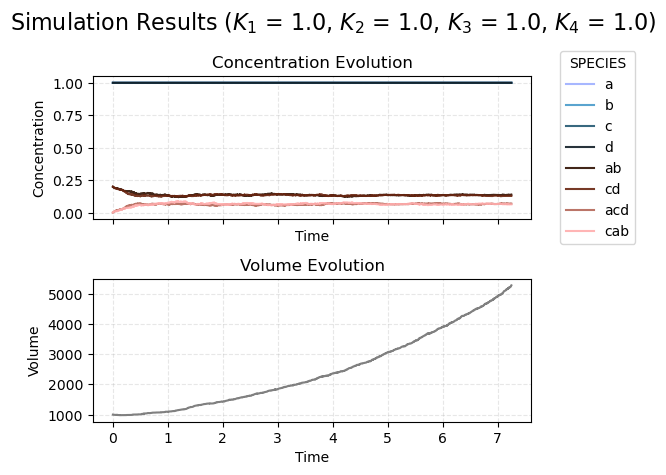

Finished V=1000. Max SD in block: 8.1012e-04

Running simulation for Volume V = 3,162
Criterion for stop was # of iterations


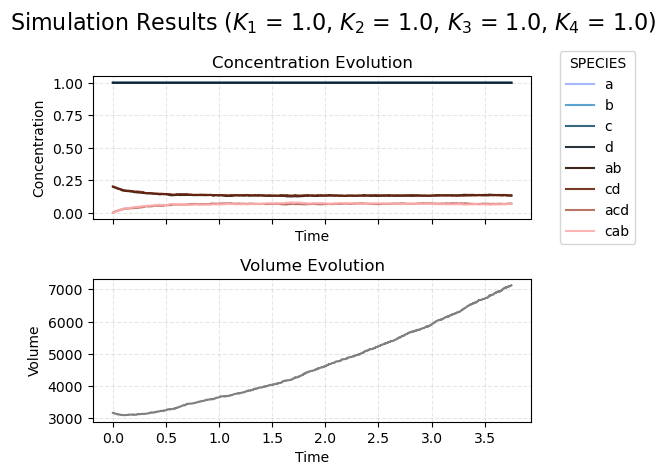

Finished V=3162. Max SD in block: 1.2040e-03

Running simulation for Volume V = 10,000
Criterion for stop was # of iterations


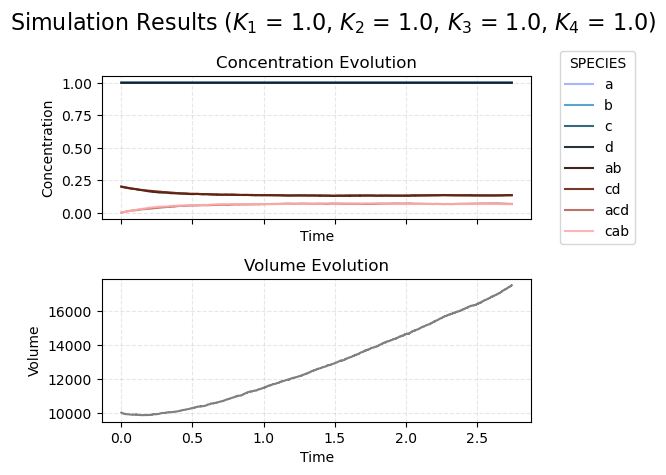

Finished V=10000. Max SD in block: 4.0804e-04

Running simulation for Volume V = 31,623
Criterion for stop was # of iterations


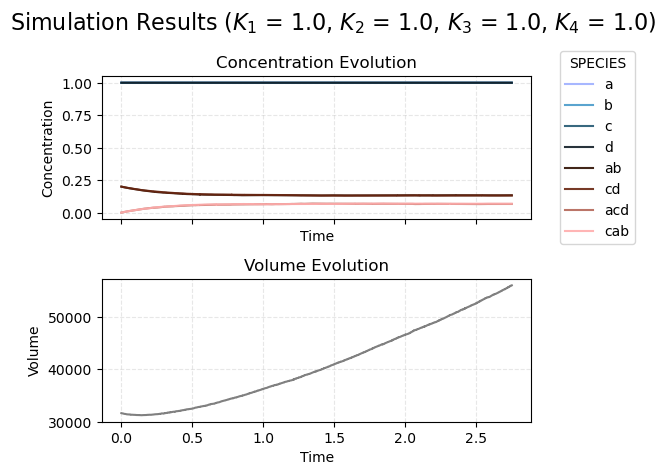

Finished V=31623. Max SD in block: 8.4893e-05

Running simulation for Volume V = 100,000


In [ ]:
concentrations = np.linspace(0.1, 1, 10)
# --- 1. PARAMETER DEFINITION ---
# Volume range: 1e2 to 1e6 (using logarithmic steps)
VOLUME_EXPONENTS = np.arange(2, 5.5, 0.5) # [2.0, 2.5, 3.0, ..., 6.0]
VOLUMES = 10**VOLUME_EXPONENTS

# Fixed parameters for the simulation
# Adjust these based on your specific reactions file
REACTIONS_FILE = "../examples/reactions_autocat.txt" 
K_CONSTANTS = [1.0] * 8  # Example: ensure length matches number of reactions
SD_THRESHOLD = 0     # Convergence threshold
MAX_ITERATIONS = VOLUMES * 2  # Safety limit for gillespieProtocell

# Load species list from your file to ensure correct ordering
reactions = read_file(REACTIONS_FILE)
SPECIES = obtain_species(reactions) 


for c in concentrations:
    print(f"Starting simulations for catalyst concentration = {c}")
    INITIAL_CONCENTRATIONS = {
        'a': 1.0,
        'b': 1.0,
        'c': 1.0,
        'd': 1.0,
        'ab': c,
        'cd': c,
        'cab': 0.0,
        'acd': 0.0
    }
    
    # Storage for results: [Volume, SD_species_A, SD_species_B, ...]
    results_list = []

    # --- 2. SIMULATION LOOP ---
    print(f"Starting {len(VOLUMES)} simulations...")
    i=0
    for V in VOLUMES:
        V = round(V) # Ensure Volume is a clean integer
        print(f"\nRunning simulation for Volume V = {V:,.0f}")
        
        # Calculate Initial Molecule Counts (N = C * V)
        initial_abundances = np.array([
            round(INITIAL_CONCENTRATIONS.get(s, 0.0) * V) for s in SPECIES
        ])
        
        # Run the simulation using the Protocell method and convergence threshold
        try:
            # chemistry calls gillespieProtocell(..., threshold)
            abundances, times, final_V = chemistry(
                method='Protocell', 
                iterations=max(MAX_ITERATIONS[i], 1e4), # Pass max_iterations as the safety limit
                reactions=reactions, 
                initial_food=initial_abundances, 
                k=K_CONSTANTS, 
                V=V, 
                threshold=SD_THRESHOLD # Passed via **kwargs logic
            )
            i += 1
            plot(abundances, times, final_V)
        except Exception as e:
            print(f"Simulation failed for V={V}: {e}")
            continue # Skip to the next volume

        # --- 3. ANALYSIS (Final Block SD) ---
        # The last 500 iterations are assumed to be the stationary block
        BLOCK_SIZE = 500
        
        if len(abundances) < BLOCK_SIZE:
            print(f"Skipping analysis: Simulation ended too soon (N={len(abundances)})")
            continue

        # 1. Slice the last block of data (Abundance)
        abundances_slice = abundances[-BLOCK_SIZE:, :]
        # 2. Slice the corresponding volumes
        V_slice = final_V[-BLOCK_SIZE:]
        
        # 3. Calculate Concentration: (Abundance / Volume) for the last block
        # Note the use of np.newaxis for correct broadcasting (from previous discussion)
        last_block_concentrations = abundances_slice / V_slice[:, np.newaxis]

        # 4. Calculate Block Statistics (only the SD is needed)
        # The block_statistics function returns (block_mean, block_std)
        block_std = block_statistics(last_block_concentrations)
        
        # 5. Store the results: [Volume, SD for species 0, SD for species 1, ...]
        results_row = [V] + block_std.tolist()
        results_list.append(results_row)
        
        print(f"Finished V={V}. Max SD in block: {np.max(block_std):.4e}")

    # Convert results to a NumPy array for easier plotting
    results_array = np.array(results_list)


    # -- Representation --


    if results_array.size == 0:
        print("No successful simulation data to plot.")
    else:
        volumes_plotted = results_array[:, 0]
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Plot SD vs Volume for each species (skipping the first column, which is V)
        for i, species_name in enumerate(SPECIES):
            if species_name != 'a' and species_name != 'b' and species_name != 'c' and species_name != 'd':
                std_devs = results_array[:, i + 1] # SD starts at column 1
                
                # We expect a relationship close to Noise ~ 1/sqrt(V)
                # Plotting on log-log axes is standard for noise analysis.
                ax.loglog(volumes_plotted, std_devs, 
                        marker='o', linestyle='-', markersize=5, 
                        label=fr'Species {species_name}'
                )

        ax.set_xlabel('Volume')
        ax.set_ylabel(r'Stationary State Standard Deviation ($\sigma$)')
        ax.grid(True, which="both", ls="--", alpha=0.5)
        ax.legend(title='Species')
        
        plt.tight_layout()
        plt.show()
        print("Plot generated successfully.")
        

    # -- --

    # Data estimated from your plot (reusing the assumed data from the previous step)
    VOLUMES = results_array[:,0]

    # Example: Using the measured SD for Species ab (as one representative example)
    # In practice, you'd calculate A for the species that drives the convergence.
    SD_ab = results_array[:,5]

    # For a single general threshold, we'll use the maximum SD across all species at each volume.
    # Let's define the 'driving' SD (the largest noise source)
    SD_cd = results_array[:,6]
    SD_acd = results_array[:,7]
    SD_cab = results_array[:,8]

    # Find the maximum SD among the species for each volume (this determines when max(std) stops decreasing)
    all_sds = np.vstack([SD_ab, SD_cd, SD_acd, SD_cab])
    driving_SD = np.max(all_sds, axis=0)


    # -- Ajuste --

    # 1. Fit the scaling law to your data
    threshold_predictor = get_scaling_threshold(VOLUMES, driving_SD, margin=0.)

    # 2. Use the returned function to predict thresholds for new, unseen volumes
    V_new_example_1 = 5000 
    V_new_example_2 = 800000

    sd_threshold_1 = threshold_predictor(V_new_example_1)
    sd_threshold_2 = threshold_predictor(V_new_example_2)

    print("\n--- Example Predictions ---")
    print(f"Predicted SD Threshold for V={V_new_example_1}: {sd_threshold_1:.4e}")
    print(f"Predicted SD Threshold for V={V_new_example_2}: {sd_threshold_2:.4e}")


    # --- PLOTTING THE FITTED VALUES FOR THRESHOLD ---
    volumes_plotted = results_array[:, 0]

    fig, ax = plt.subplots(figsize=(10, 6))


    # We expect a relationship close to Noise ~ 1/sqrt(V)
    # Plotting on log-log axes is standard for noise analysis.
    ax.loglog(volumes_plotted, driving_SD, 
            marker='o', linestyle='-', markersize=5, 
            label=fr'Max SD from simulation'
    )

    threshold_predicted = []
    for v in volumes_plotted:
            threshold_predicted.append(threshold_predictor(v))

    threshold_predicted = np.array(threshold_predicted)

    ax.loglog(volumes_plotted, threshold_predicted, 
            marker='o', linestyle='-', markersize=5, 
            label=fr'Predicted SD'
    )

    # Now with margin
    threshold_predictor_w_margin = get_scaling_threshold(VOLUMES, driving_SD, margin=0.5)
    threshold_predicted_w_margin = []
    for v in volumes_plotted:
            threshold_predicted_w_margin.append(threshold_predictor_w_margin(v))

    threshold_predicted_w_margin = np.array(threshold_predicted_w_margin)

    ax.loglog(volumes_plotted, threshold_predicted_w_margin, 
            marker='o', linestyle='-', markersize=5, 
            label=fr'Predicted SD + margin'
    )

    ax.set_xlabel('Volume')
    ax.set_ylabel(r'Stationary State Standard Deviation ($\sigma$)')
    ax.grid(True, which="both", ls="--", alpha=0.5)
    ax.legend()

    plt.tight_layout()
    plt.show()
    print("Plot generated successfully.")